In [21]:
%%html
<style>
div.input {
    display:none;
}
</style>

# Spectral Visualization Tools

- Answering "what is neural noise?"
    - aperiodic signals that follow a Poisson point process
    - "white" noise and colored noise

In [1]:
import os
# the only lines you need to change to inspect different saved data
path = '/Users/ldliao/Research/Projects/spectralCV/results/kjm_digits/bp/'
os.chdir(path)

In [2]:
import sys
# locate your spectralCV so we have scv_funcs to use
sys.path.append('/Users/ldliao/Research/Projects/spectralCV/')
sys.path.append('/Users/ldliao/Research/Projects/spectralCV/notebooks_visualization/')

In [18]:
# %load_ext autoreload
# %autoreload 2

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

from scipy.stats import expon
import glob

import neurodsp as ndsp
from neurodsp import sim
from scv_funcs import lfpca, utils
import warnings
warnings.filterwarnings('ignore')

In [4]:
# @hidden_cell
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
syn_noise = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    syn_noise[tr,:] = sim.sim_synaptic_noise(T,fs,tau_r=tauR,tau_d=tauD)
    
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
sn_lfpca = lfpca.LFPCA(params)
sn_lfpca.populate_ts_data(syn_noise,fs)
sn_lfpca.compute_all_spectral()
sn_lfpca.compute_KS_expfit()

## Noise Simulation

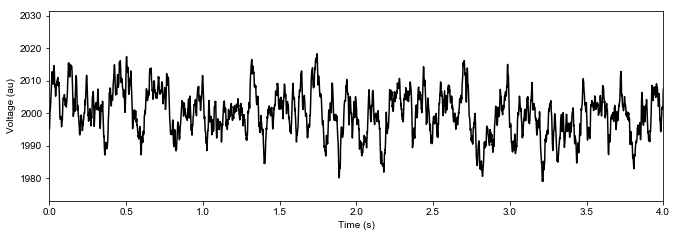

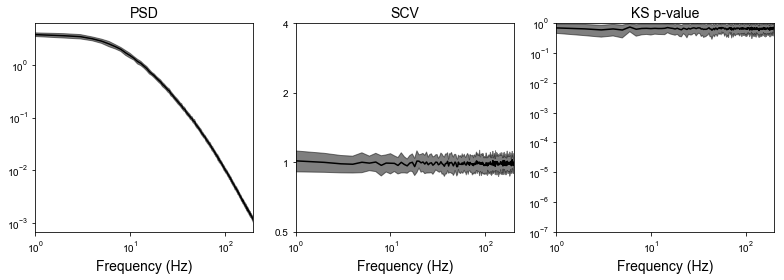

In [5]:
plt.figure(figsize=(11,3.5))
plt.plot(np.arange(0,T,1/fs),syn_noise[0,:], 'k')
plt.xlabel('Time (s)'), plt.ylabel('Voltage (au)'), plt.xlim([0,4]), plt.figure(figsize=(11,4))
sn_lfpca.plot_spectral(plot_mean=True)

### Simulation with sustained and bursting oscillations 

In [7]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
theta_freq=4
theta_amp=15
beta_freq=23
beta_amp=6
syn_osc = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    noise = sim.sim_synaptic_noise(T,fs,tau_r=tauR,tau_d=tauD)
    # stationary theta: high entering probability and low leaving probability
    theta = sim.sim_bursty_oscillator(T,fs, theta_freq, rdsym=0.5, prob_enter_burst=1, prob_leave_burst=0.1)
    # bursty beta: low entering probability and low leaving probability
    beta = sim.sim_bursty_oscillator(T,fs, beta_freq, rdsym=0.5, prob_enter_burst=0.1, prob_leave_burst=0.1)
    syn_osc[tr,:] = noise+theta_amp*theta+beta_amp*beta

# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()

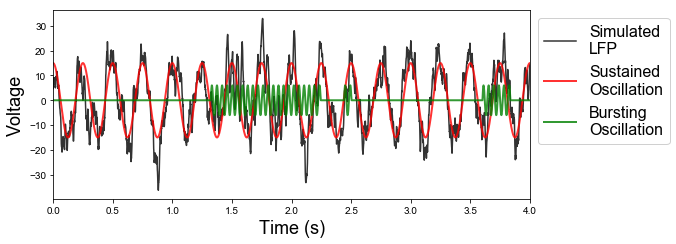

In [8]:
plot_tr = -1
plt.figure(figsize=(9.5,3.5))
plt.plot(np.arange(0,4,1/fs), syn_osc[plot_tr,4000:8000]-syn_osc[plot_tr,4000:8000].mean(), 'k', alpha=0.8, label='Simulated\nLFP')
plt.plot(np.arange(0,4,1/fs), theta_amp*theta[4000:8000], lw=2, alpha=0.8, color='r', label='Sustained\nOscillation')
plt.plot(np.arange(0,4,1/fs), beta_amp*beta[4000:8000],lw=2, alpha=0.8, color='g', label='Bursting\nOscillation')
plt.xlim([0,4])
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Voltage', fontsize=18)
plt.legend(loc='upper right',fontsize=18)
plt.legend(loc='upper left', fontsize=16, framealpha=0.9,bbox_to_anchor=(1, 1))
plt.tight_layout()

#### Simulation with sustained and bursting oscillations - analysis

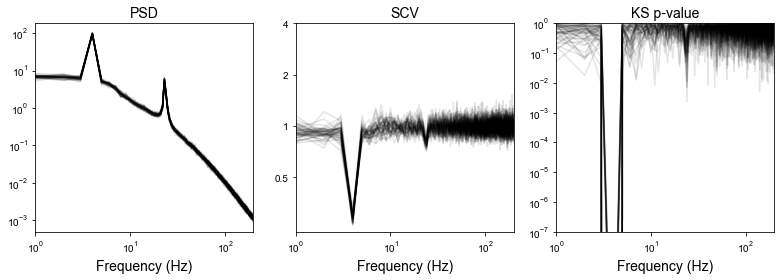

In [9]:
plt.figure(figsize=(11,4))
osc_lfpca.plot_spectral(plot_mean=False)

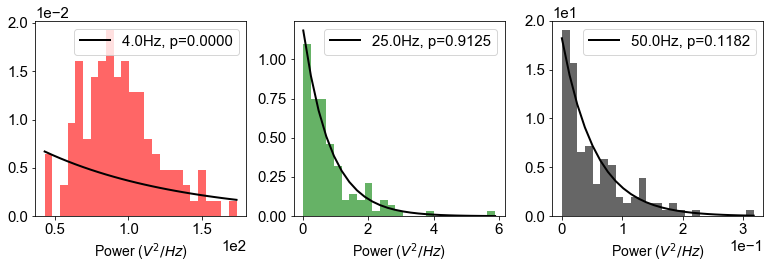

In [19]:
plt.figure(figsize=(11,4))
plot_freqs = [4,25,50]
plot_colors = ['r','g','k']
for i in range(3):
    plt.subplot(1,3,i+1)
    osc_lfpca.plot_expfit(plot_tr,plot_freqs[i],25)
    ax = plt.gca()
    [[p.set_facecolor(plot_colors[i]),p.set_alpha(0.6)] for p in ax.patches]
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.tight_layout()

### Bokeh visualization on real data:
#### PSD, SCV, and power distribution

In [11]:
# bokeh imports
import bokeh
from bokeh.io import push_notebook, show, output_notebook, curdoc
from bokeh.io import *
from bokeh.plotting import figure
from bokeh.layouts import gridplot, row, column
from bokeh.models import ColumnDataSource, TapTool, Slider, Span, CustomJS
from bokeh.models.widgets import PreText, Select, Slider
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

output_notebook()

Loading BokehJS ...

In [13]:
def modify_doc(doc):

    # collect all the names of .npz files in the folder
    lfpca_all_names = glob.glob("*.npz")
    lfpca_all_names.sort()
    
    # loading the npz files 
    lfpca_all = {}
    for ind, lf in enumerate(lfpca_all_names):
        lfpca_all[lf[:-4]] = lfpca.lfpca_load_spec(lf)

    # initialize with the first lfpca object
    lf = lfpca_all[lfpca_all_names[0][:-4]]

    # grabbing channel count from psd
    chan_count, freq = lf.psd.shape

    # mapping all the channels
    DEFAULT_TICKERS = list(map(str, range(chan_count)))
    LF_TICKERS = [key for key in lfpca_all.keys()]

    # initializing values for frequency, psd, scv, histogram plot
    chan = 0
    select_freq = 10
    select_bin = 20
    freq_vals = lf.f_axis[1:]
    psd_vals = lf.psd[chan].T[1:]
    scv_vals = lf.scv[chan].T[1:]

    # creating a selector and slider
    lf_ticker = Select(value=lfpca_all_names[0][:-4], title='lf_condition', options=LF_TICKERS)
    ticker = Select(value=str(chan), title='channel', options=DEFAULT_TICKERS)
    freq_slider = Slider(start=1, end=199, value=select_freq, step=1, title="Frequency", callback_policy="mouseup")
    bin_slider = Slider(start=10, end=55, value=select_bin, step=5, title="Number of bins", callback_policy="mouseup")

    # create data and selection tools
    source = ColumnDataSource(data=dict(freq_vals=freq_vals, psd_vals=psd_vals, scv_vals=scv_vals))

    TOOLS = "help" #tapTool work in progress

    # setting up plots
    psd_plot = figure(tools=TOOLS, title='PSD', x_axis_type='log', y_axis_type='log')
    psd_plot.legend.location = 'top_left'
    psd_plot.xaxis.axis_label = 'Frequency (Hz)'
    psd_plot.yaxis.axis_label = 'Power/Frequency (dB/Hz)'
    psd_plot.grid.grid_line_alpha=0.3

    scv_plot = figure(tools=TOOLS, title='SCV', x_axis_type='log', y_axis_type='log')
    scv_plot.legend.location='top_left'
    scv_plot.xaxis.axis_label = 'Frequency (Hz)'
    scv_plot.yaxis.axis_label = '(Unitless)'
    scv_plot.grid.grid_line_alpha=0.3

    # create histogram frame
    hist_source = ColumnDataSource({'top': [], 'left': [], 'right': []})
    fit_hist_source = ColumnDataSource({'x': [], 'y': []})
    hist, edges = np.histogram(lf.spg[chan, select_freq, :], bins=select_bin, density=True)
    hist_source.data = {'top': hist, 'left': edges[:-1], 'right': edges[1:]}

    # create fit line for the histogram
    rv = expon(scale=sp.stats.expon.fit(lf.spg[chan,select_freq,:],floc=0)[1])
    hist_source.data = {'top': hist, 'left': edges[:-1], 'right': edges[1:]}
    fit_hist_source.data = {'x': edges, 'y': rv.pdf(edges)}

    hist_fig = figure(x_axis_label='Power', 
                      y_axis_label='Probability', background_fill_color="#E8DDCB")
    hist_fig.axis.visible = False
    hist_fig.title.text = 'Freq = %.1fHz, p-value = %.4f'%(select_freq, lf.ks_pvals[chan, select_freq])


    # customize plot to psd
    def create_psd_plot(psd_plot, source):
        psd_plot.line('freq_vals', 'psd_vals', source=source, color='navy')
#         psd_plot.circle('freq_vals', 'psd_vals', source=source, size=5, color='darkgrey', alpha=0.2, 
#                         # set visual properties for selected glyphs
#                         selection_color="firebrick",
#                         # set visual properties for non-selected glyphs
#                         nonselection_fill_alpha=0.2,
#                         nonselection_fill_color="darkgrey",
#                         name='psd_circ')
    # customize plot to psd
    def create_scv_plot(scv_plot, source):
        fit_line = bokeh.models.glyphs.Line(x='freq_vals', y=1, line_width=5, line_alpha=0.5, line_color='darkgrey')
        scv_plot.add_glyph(source, fit_line)
        scv_plot.line('freq_vals', 'scv_vals', source=source, color='navy')
#         scv_plot.line(source['freq_vals'], np.ones(len(source['scv_vals'])), color='k')
#         scv_plot.circle('freq_vals', 'scv_vals', source=source, size=5, color='darkgrey', alpha=0.2, 
#                         # set visual properties for selected glyphs
#                         selection_color="firebrick",
#                         # set visual properties for non-selected glyphs
#                         nonselection_fill_alpha=0.2,
#                         nonselection_fill_color="darkgrey",
#                         name='scv_circ')

    # customize histogram
    def create_hist(hist_fig, hist_source):
        hist_fig.quad(top='top', bottom=0, left='left', right='right', fill_color="#036564", line_color="#033649", source=hist_source)

    # initializing plots
    create_psd_plot(psd_plot, source)
    create_scv_plot(scv_plot, source)
    vline_psd = Span(location=select_freq, dimension='height', line_color='red', line_dash='dashed', line_width=3)
    vline_scv = Span(location=select_freq, dimension='height', line_color='red', line_dash='dashed', line_width=3)
    psd_plot.add_layout(vline_psd)
    scv_plot.add_layout(vline_scv)
    create_hist(hist_fig, hist_source)
    fit_line = bokeh.models.glyphs.Line(x='x', y='y', line_width=8, line_alpha=0.7, line_color="#D95B43")
    hist_fig.add_glyph(fit_hist_source, fit_line)

    all_plots = gridplot([[psd_plot, scv_plot, hist_fig]], plot_width=300, plot_height=300)

    # set up connector spans
    freq_slider.callback = CustomJS(args=dict(span1 = vline_psd,
                                              span2 = vline_scv,
                                              slider = freq_slider),
                                              code = """span1.location = slider.value; 
                                                        span2.location = slider.value""")

    def update(attrname, old, new):
        # get current slider values
        chan = int(ticker.value)
        lf = lfpca_all[lf_ticker.value]
        select_freq = freq_slider.value
        select_bin = bin_slider.value

        # update data
        psd_vals = lf.psd[chan].T[1:]
        scv_vals = lf.scv[chan].T[1:]
        data = dict(freq_vals=freq_vals, psd_vals=psd_vals, scv_vals=scv_vals)
        # create a column data source for the plots to share
        source.data = data

        # update histogram and fit line
        hist, edges = np.histogram(lf.spg[chan, select_freq, :], bins=select_bin, density=True)
        rv = expon(scale=sp.stats.expon.fit(lf.spg[chan,select_freq,:],floc=0)[1])
        hist_source.data = {'top': hist, 'left': edges[:-1], 'right': edges[1:]}
        fit_hist_source.data = {'x': edges, 'y': rv.pdf(edges)}
        create_psd_plot(psd_plot=psd_plot, source=source)
        create_scv_plot(scv_plot=scv_plot, source=source)
        hist_fig.title.text = 'Freq = %.1fHz, p-value = %.4f'%(select_freq, lf.ks_pvals[chan, select_freq])
        create_hist(hist_fig=hist_fig, hist_source=hist_source)
        fit_line = bokeh.models.glyphs.Line(x='x', y='y', line_width=8, line_alpha=0.7, line_color="#D95B43")
        hist_fig.add_glyph(fit_hist_source, fit_line)

    # whenever a widget changes, the changes are tracked and histogram always updated
    for widget in [lf_ticker, ticker, bin_slider, freq_slider]:
        widget.on_change('value', update)

    
    # organize layout
    widgets = row(lf_ticker, ticker)
    sliders = row(freq_slider, bin_slider)
    layout = column(widgets, sliders, all_plots)
    doc.add_root(layout)
    
# In the notebook, just pass the function that defines the app to show
show(modify_doc, notebook_handle=True)
# curdoc().add_root(layout) - for .py file

#### Comparative tool with PSD and SCV

In [15]:
def modify_doc(doc):

    # collect all the names of .npz files in the folder
    lfpca_all_names = glob.glob("*.npz")
    lfpca_all_names.sort()
    
    # loading the npz files 
    lfpca_all = {}
    for ind, lf in enumerate(lfpca_all_names):
        lfpca_all[lf[:-4]] = lfpca.lfpca_load_spec(lf)

    # initialize with the first lfpca object
    lf1 = lfpca_all[lfpca_all_names[0][:-4]]
    lf2 = lfpca_all[lfpca_all_names[1][:-4]]
    
    # grabbing channel count from psd
    chan_count, freq = lf1.psd.shape

    # mapping all the channels
    CH_TICKERS = list(map(str, range(chan_count)))
    LF_TICKERS = [key for key in lfpca_all.keys()]
    
    def nix(val, lst):
        return [x for x in lst if x != val]

    # initializing values for frequency, psd, scv, histogram plot
    chan = 0
#     select_freq = 10
    freq_vals_1 = lf1.f_axis[1:]
    freq_vals_2 = lf2.f_axis[1:]
    psd_vals_1 = lf1.psd[chan].T[1:]
    psd_vals_2 = lf2.psd[chan].T[1:]
    scv_vals_1 = lf1.scv[chan].T[1:] 
    scv_vals_2 = lf2.scv[chan].T[1:]

    # creating a selector and slider
    lf_ticker_1 = Select(value=lfpca_all_names[0][:-4], title='condition_1', 
                         options=nix(lfpca_all_names[1][:-4], LF_TICKERS))
    lf_ticker_2 = Select(value=lfpca_all_names[1][:-4], title='condition_2', 
                         options=nix(lfpca_all_names[0][:-4], LF_TICKERS))

    ch_ticker = Select(value=str(chan), title='channel', options=CH_TICKERS)
#     freq_slider = Slider(start=1, end=199, value=select_freq, step=1, title="Frequency", callback_policy="mouseup")

    # create data and selection tools
    source_1 = ColumnDataSource(data=dict(freq_vals_1=freq_vals_1, psd_vals_1=psd_vals_1, scv_vals_1=scv_vals_1))
    source_2 = ColumnDataSource(data=dict(freq_vals_2=freq_vals_2, psd_vals_2=psd_vals_2, scv_vals_2=scv_vals_2))

    # TOOLS = "help" #tapTool work in progress

    # setting up plots
    psd_plot = figure(title='PSD', x_axis_type='log', y_axis_type='log')
    psd_plot.legend.location = 'top_left'
    psd_plot.xaxis.axis_label = 'Frequency (Hz)'
    psd_plot.yaxis.axis_label = 'Power/Frequency (dB/Hz)'
    psd_plot.grid.grid_line_alpha=0.3

    scv_plot = figure(title='SCV', x_axis_type='log', y_axis_type='log')
    scv_plot.legend.location='top_left'
    scv_plot.xaxis.axis_label = 'Frequency (Hz)'
    scv_plot.yaxis.axis_label = '(Unitless)'
    scv_plot.grid.grid_line_alpha=0.3

    # customize plot to psd
    def create_psd_plot(psd_plot, source_1, source_2):
        psd_plot.line('freq_vals_1', 'psd_vals_1',  source=source_1, 
                      color='navy', muted_color='navy', muted_alpha=0.2, 
                      legend='cond_1')
        psd_plot.line('freq_vals_2', 'psd_vals_2',  source=source_2, 
                      color="green", muted_color='green', muted_alpha=0.2, legend='cond_2')
        psd_plot.legend.location = "bottom_left"
        psd_plot.legend.click_policy="mute"
        
    # customize plot to psd
    def create_scv_plot(scv_plot, source_1, source_2):
        fit_line = bokeh.models.glyphs.Line(x='freq_vals_1', y=1, line_width=5, line_alpha=0.5, line_color='darkgrey')
        scv_plot.add_glyph(source_1, fit_line)
        scv1 = scv_plot.line('freq_vals_1', 'scv_vals_1',  source=source_1, 
                      line_color="navy", muted_alpha=0.2, legend='cond_1')
                      # legend=lf_ticker_1.value)
        scv2 = scv_plot.line('freq_vals_2', 'scv_vals_2',  source=source_2, 
                      line_color="green", muted_alpha=0.2, legend='cond_2')
                      # legend=lf_ticker_2.value)
        scv_plot.legend.location = "bottom_left"
        scv_plot.legend.click_policy="mute"

    # initializing plots
    create_psd_plot(psd_plot, source_1, source_2)
    create_scv_plot(scv_plot, source_1, source_2)
#     vline_psd = Span(location=select_freq, dimension='height', line_color='red', line_dash='dashed', line_width=3)
#     vline_scv = Span(location=select_freq, dimension='height', line_color='red', line_dash='dashed', line_width=3)
#     psd_plot.add_layout(vline_psd)
#     scv_plot.add_layout(vline_scv)

    all_plots = gridplot([[psd_plot, scv_plot]], plot_width=450, plot_height=400)

    # set up connector spans
#     freq_slider.callback = CustomJS(args=dict(span1 = vline_psd,
#                                               span2 = vline_scv,
#                                               slider = freq_slider),
#                                               code = """span1.location = slider.value; 
#                                                         span2.location = slider.value""")


    def update(selected=None):
        # get current slider values
        chan = int(ch_ticker.value)
        lf1 = lfpca_all[lf_ticker_1.value]
        lf2 = lfpca_all[lf_ticker_2.value]
#         select_freq = freq_slider.value

        # update data
        freq_vals_1 = lf1.f_axis[1:]
        freq_vals_2 = lf2.f_axis[1:]
        psd_vals_1 = lf1.psd[chan].T[1:]
        psd_vals_2 = lf2.psd[chan].T[1:]
        scv_vals_1 = lf1.scv[chan].T[1:] 
        scv_vals_2 = lf2.scv[chan].T[1:]
        data_1 = dict(freq_vals_1=freq_vals_1, psd_vals_1=psd_vals_1, scv_vals_1=scv_vals_1)
        data_2 = dict(freq_vals_2=freq_vals_2, psd_vals_2=psd_vals_2, scv_vals_2=scv_vals_2)

        # create a column data source for the plots to share
        source_1.data = data_1
        source_2.data = data_2
#         scv_plot.line('freq_vals_1', 'scv_vals_1',  source=source_1, 
#                       line_color="navy", muted_alpha=0.2, legend=lf_ticker_1.value)


#     # whenever a widget changes, the changes are tracked and histogram always updated
#     for widget in [lf_ticker, ticker, freq_slider]:
#         widget.on_change('value', update)

    def lf_ticker_1_change(attrname, old, new):
        lf_ticker_2.options = nix(new, LF_TICKERS)
        update()

    def lf_ticker_2_change(attrname, old, new):
        lf_ticker_1.options = nix(new, LF_TICKERS)
        update()
    
    def ch_ticker_change(attrname, old, new):
        update()
    
    lf_ticker_1.on_change('value', lf_ticker_1_change)
    lf_ticker_2.on_change('value', lf_ticker_2_change)
    ch_ticker.on_change('value', ch_ticker_change)

    # organize layout
    widgets = row(lf_ticker_1, lf_ticker_2, ch_ticker)
#    sliders = row(freq_slider)
#    layout = column(widgets, sliders, all_plots)
    layout = column(widgets, all_plots)
    doc.add_root(layout)
    
# In the notebook, just pass the function that defines the app to show
show(modify_doc, notebook_handle=True)
# curdoc().add_root(layout) - for .py file